# LLamo a las librerias necesarias

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pyVHR.BVP.filters as filters
import pyVHR.BVP as Bvplib
import pyVHR.extraction.utils as utils
from pyVHR.analysis import Pipeline
from importlib import import_module, util


# Llamo a run_on_video() 

para analizar el video y obtener:+ 

TimesEs= un vector que contiene los tiempos ubicados en el centro de cada una de las ventanas del video\

median_bpmES= Esta variable representa la mediana de las estimaciones de BPM

mad_bpmES= Esta variable representa la desviación estándar de las estimaciones de BPM

bvps= Esta variable es una lista de valores que contienen los datos de bvps 

bvps_completa= Esta variable contiene las bvps concatenadas a lo largo de todas las ventanas de tiempo

sig_completa= Esta variable contiene la senial RGB sin segmentar

se utiliza el metodo convexhull por ser el mas sencillo, y tambien se utiliza el metodo holistic porque si bien el de parches es mas preciso, consume mucho mas


In [18]:
pipe=Pipeline()
timesES, median_bpmES, mad_bpmES, bvps, bvps_completa, sig_completa  = pipe.run_on_video('output.avi')


Processing Video: output.avi


c:\Users\alkas\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



BVP extraction with method: cpu_POS

BPM estimation with: welch

...done!



#aca hice algunos prints que me resultaron utiles para el debug y ademas asigne el valor de fps a la variable fps

#BORRAR

In [19]:

fps=utils.get_fps("output.avi")
print(fps)
print(sig_completa.shape[0])
print(len(bvps_completa[0]))
print(bvps_completa)
print (len(bvps[0][0]))

#for i, bvp in enumerate(bvps):
 #   print(f"Winhdow {i}: BVP shape = {bvp.shape}")
    
    


20.0
388
1680
[array([ 0.00000000e+00,  3.05448858e-09, -2.70570357e-08, ...,
       -6.77244073e-03, -5.27537207e-03, -2.74534819e-03])]
120


# Grafica de las BVPs

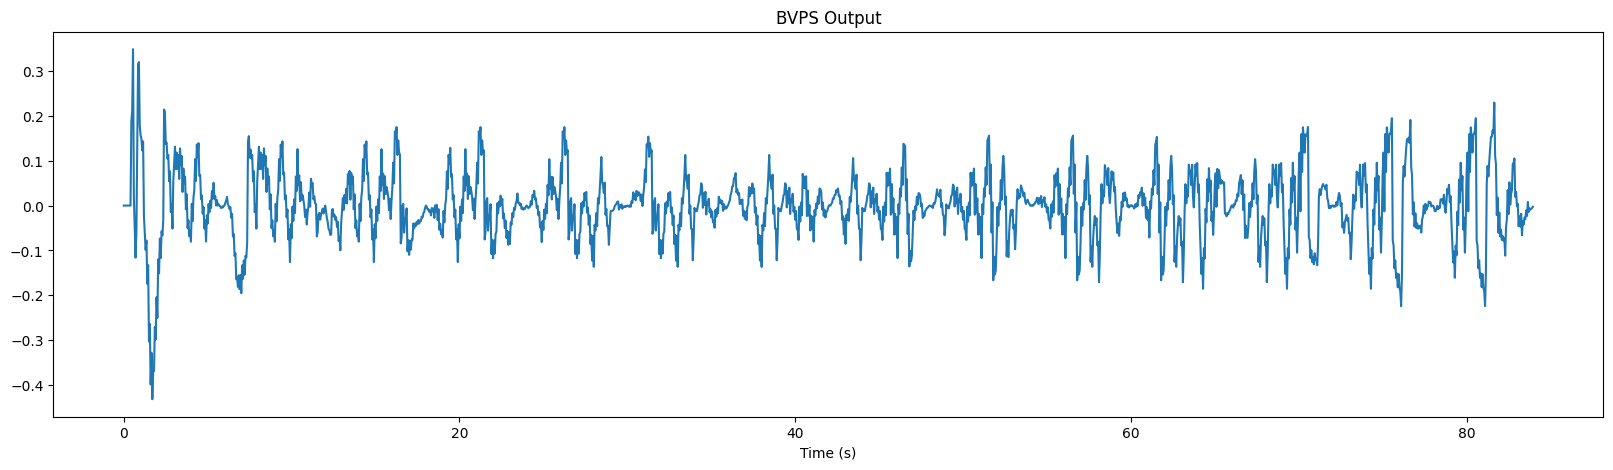

In [20]:
 
num_frames = len(bvps_completa[0])
time = np.arange(num_frames) / fps

plt.figure(figsize=(20,5))
plt.plot(time, bvps_completa[0])
plt.xlabel('Time (s)')
plt.title('BVPS Output')
plt.show()


# Filtrado De las BVP

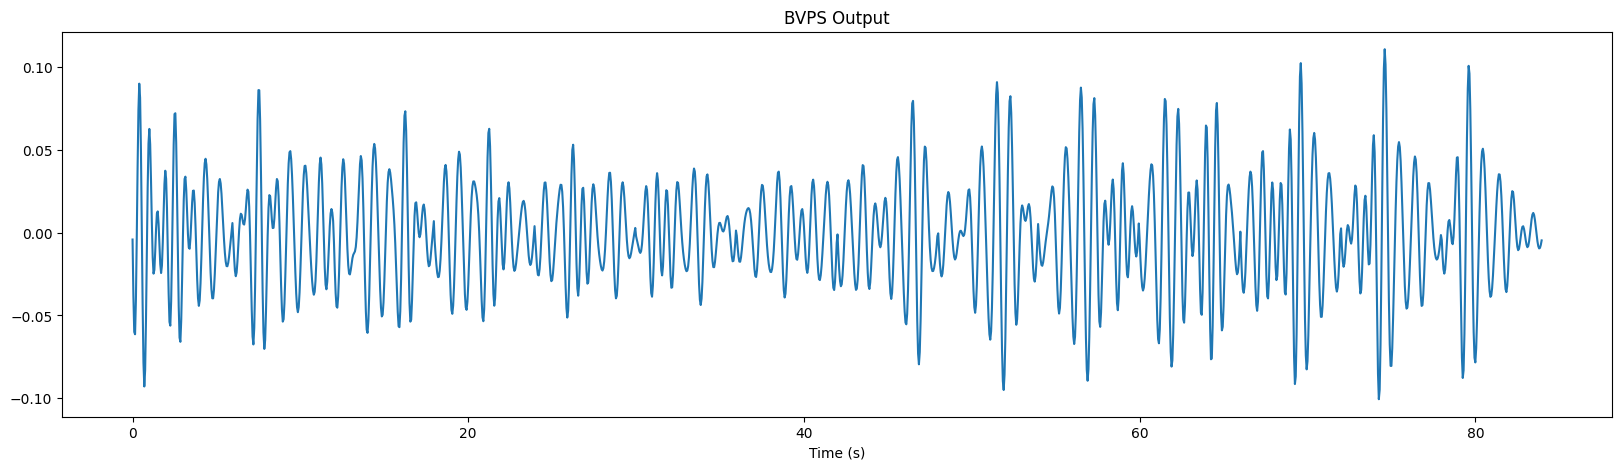

In [21]:
module = import_module('pyVHR.BVP.filters')
method_to_call = getattr(module, 'BPfilter')

bvps_filtrada = filters.apply_filter(bvps, 
                                method_to_call, 
                                fps=fps, 
                                params={'minHz':1, 'maxHz':2, 'fps':'adaptive', 'order':6})

bvps_filtrada = Bvplib.concatenate_BVPs(bvps_filtrada)

# Calcular el tiempo en segundos para cada frame
num_frames = len(bvps_filtrada[0])
time = np.arange(num_frames) / fps

plt.figure(figsize=(20,5))
plt.plot(time, bvps_filtrada[0])
plt.xlabel('Time (s)')
plt.title('BVPS Output')
plt.show()

# Grafica de la senial RGB

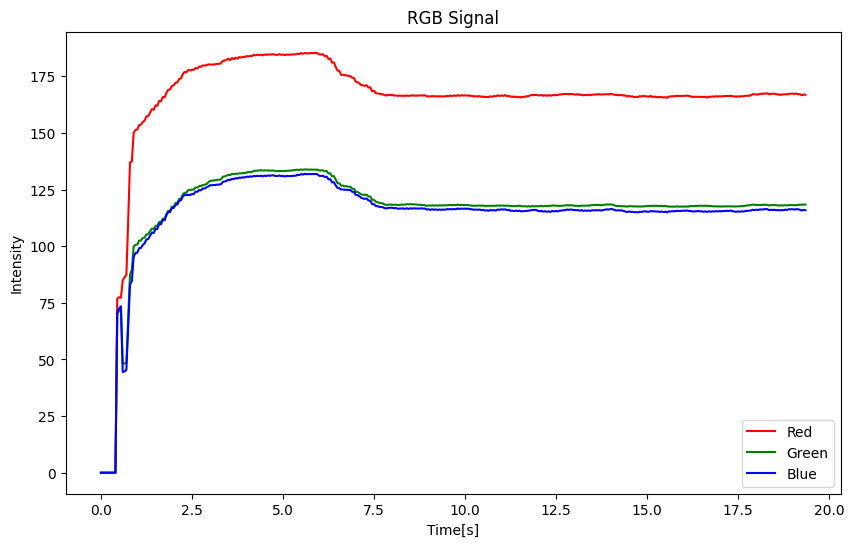

In [22]:

num_frames = sig_completa.shape[0]  #sig shape devuelve la dimension de la matriz senial de esta forma obtiene la cantidad de frames
time = np.arange(num_frames) / fps
# Separate the color channels
red_signal = sig_completa[:, 0, 0]
green_signal = sig_completa[:, 0, 1]
blue_signal = sig_completa[:, 0, 2]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the color channels
ax.plot(time, red_signal, label='Red', color='r')
ax.plot(time, green_signal, label='Green', color='g')
ax.plot(time, blue_signal, label='Blue', color='b')

# Set labels and title
ax.set_xlabel('Time[s]')
ax.set_ylabel('Intensity')
ax.set_title('RGB Signal')

# Add a legend
ax.legend()

# Show the plot
plt.show()


# Senial BPM

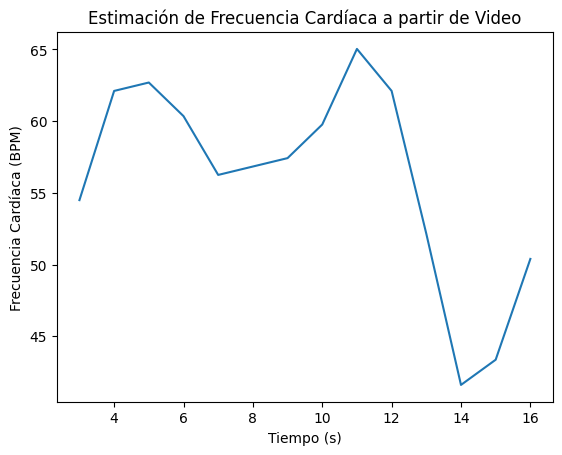

In [23]:
plt.figure()
plt.plot(timesES, median_bpmES)
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.title('Estimación de Frecuencia Cardíaca a partir de Video')
plt.show()
    

In [24]:
print(median_bpmES)
len(bvps[0][0])

[54.4921875 62.109375  62.6953125 60.3515625 56.25      56.8359375
 57.421875  59.765625  65.0390625 62.109375  52.1484375 41.6015625
 43.359375  50.390625 ]


120

# Bland-Altman
comparacion de ecg con rppg

In [25]:
ecg_bpm = np.array([77.48357077, 74.30867849, 78.23844269, 82.61514928, 73.82923313,
                    73.82931522, 82.89606408, 78.83717365, 72.65262807, 77.71280022,
                    72.68291154, 72.67135123, 76.20981136, 65.43359878, 66.37541084,
                    72.18856235, 69.9358444 , 76.57123666, 70.45987962, 67.93848149,
                    82.32824384, 73.8711185 , 75.33764102, 67.87625907, 72.27808638,
                    75.55461295, 69.24503211, 76.87849009, 71.99680655, 73.54153125])

In [29]:
mean_bpm = (median_bpmES + median_bpmES) / 2
bias = median_bpmES - median_bpmES
upper_limit = np.mean(bias) + 1.96 * np.std(bias)
lower_limit = np.mean(bias) - 1.96 * np.std(bias)

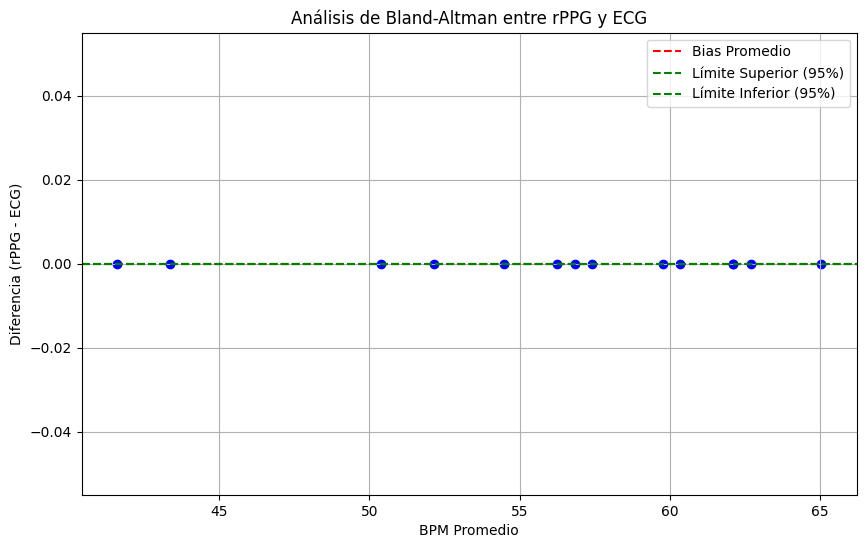

In [30]:
# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(mean_bpm, bias, color='blue')
plt.axhline(np.mean(bias), color='red', linestyle='--', label='Bias Promedio')
plt.axhline(upper_limit, color='green', linestyle='--', label='Límite Superior (95%)')
plt.axhline(lower_limit, color='green', linestyle='--', label='Límite Inferior (95%)')
plt.title('Análisis de Bland-Altman entre rPPG y ECG')
plt.xlabel('BPM Promedio')
plt.ylabel('Diferencia (rPPG - ECG)')
plt.legend()
plt.grid(True)
plt.show()